# LDA topic modelling

In [1]:
import pandas as pd

In [2]:
from pathlib import Path
d = Path().resolve().parent.parent.parent

d = str(d) + "/data/original/papers.csv"

papers = pd.read_csv(d)
papersArray = papers.paper_text
papersId = papers.id

## Cleaning and Preprocessing
Stop words and puctualization elimination, lemmatization of nouns and verbs. Moreover, numbers and words with less than 4 characters are removed to clean the mathematical fomrulas from the papers. 

In [3]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string


stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer() 

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalizedFromNouns = " ".join(lemma.lemmatize(word,'n') for word in punc_free.split())
    normalizedFromVerbs = " ".join(lemma.lemmatize(word,'v') for word in normalizedFromNouns.split())
    return normalizedFromVerbs


papersArrayClean = [clean(paper).split() for paper in papersArray]
#print(papersArrayClean)


# remove words that appear less then two times
from collections import defaultdict
frequency = defaultdict(int)

for text in papersArrayClean:
     for token in text:
         frequency[token] += 1

papersArrayClean = [[token for token in text if frequency[token] > 2]
          for text in papersArrayClean]

papersArrayCleanNoNumbers = []


# removing numbers 
for doc in papersArrayClean:
    numbers = list()
    for word in doc:
            if word.isnumeric(): numbers.append(word)
    numbers = list(numbers)
    for n in numbers:
        doc.remove(n)
    papersArrayCleanNoNumbers.append(doc)
        

papersArrayCleanNoLetter = []

# removing words with less than 4 characters 
for doc in papersArrayCleanNoNumbers:
    letters = list()
    for word in doc:
            if (len(word)<=3 ): letters.append(word)
    letters = list(letters)
    for n in letters:
        doc.remove(n)
    papersArrayCleanNoLetter.append(doc)

#print(papersArrayCleanNoLetter)


## Preparing Document-Term Matrix

corpora.Dictionary just creates a dictionary that maps each unique word with a unique id 
For example {'mean': 0, 'field': 1, 'theory': 2,...}

doc2bow simply counts the number of occurrences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector. 
For example the sparse vector [(0, 19), (2, 8)] therefore reads: the words 'mean' (id 0) appears 19 times, the word 'theroy' appears 2 times etc...

Here, we decided to filter out words that occur too rarely or too frequently, to improve the performance of the the LDA model

In [4]:
# Importing Gensim
import gensim
from gensim import corpora
from gensim import models

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(papersArrayCleanNoLetter)
#print(dictionary.token2id)

print('Number of unique tokens before filtering : %d' % len(dictionary))

# Remove rare and common tokens.
# Filter out words that occur too rarely or too frequently 
# Filter out words that occur less than min_wordcount documents, or more than maxfreq of the documents.
min_wordcount = 100
max_freq = 0.3

dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)


# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(p) for p in papersArrayCleanNoLetter]
#print(doc_term_matrix)

print('Number of unique tokens after filtering: %d' % len(dictionary))



Number of unique tokens before filtering : 77405
Number of unique tokens after filtering: 3858


## Running LDA Model

In [5]:
ldamodel = models.LdaMulticore(doc_term_matrix, num_topics=8, id2word = dictionary, passes = 30, random_state=62)
lda = ldamodel[doc_term_matrix]

### general topics
Here we print the topics we have found, with the most 10 related words

In [6]:
ldamodel.print_topics(num_topics=8, num_words=10)

[(0,
  '0.031*"object" + 0.028*"layer" + 0.015*"deep" + 0.011*"convolutional" + 0.009*"pixel" + 0.008*"segmentation" + 0.007*"architecture" + 0.007*"filter" + 0.007*"visual" + 0.007*"scene"'),
 (1,
  '0.009*"posterior" + 0.009*"latent" + 0.008*"edge" + 0.008*"estimator" + 0.007*"query" + 0.007*"variational" + 0.005*"node" + 0.005*"mixture" + 0.005*"score" + 0.005*"classifier"'),
 (2,
  '0.016*"response" + 0.014*"visual" + 0.013*"stimulus" + 0.012*"cell" + 0.012*"activity" + 0.012*"filter" + 0.010*"neuron" + 0.009*"motion" + 0.009*"frequency" + 0.008*"layer"'),
 (3,
  '0.017*"node" + 0.010*"speech" + 0.009*"classifier" + 0.009*"layer" + 0.008*"tree" + 0.007*"architecture" + 0.006*"activation" + 0.006*"memory" + 0.006*"language" + 0.005*"backpropagation"'),
 (4,
  '0.046*"neuron" + 0.023*"spike" + 0.019*"cell" + 0.015*"circuit" + 0.013*"fire" + 0.010*"synaptic" + 0.009*"activity" + 0.008*"analog" + 0.008*"threshold" + 0.007*"chip"'),
 (5,
  '0.034*"policy" + 0.033*"action" + 0.023*"rewar

### wordcloud
Wordcloud visualization of the topics above

Topic 0


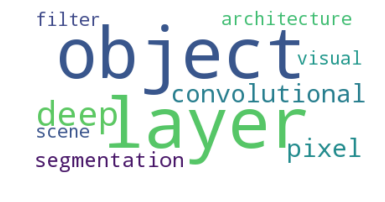

Topic 1


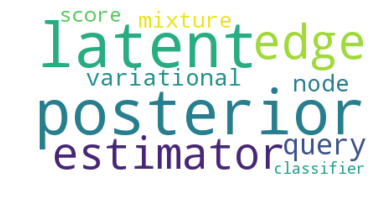

Topic 2


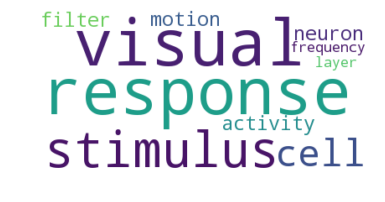

Topic 3


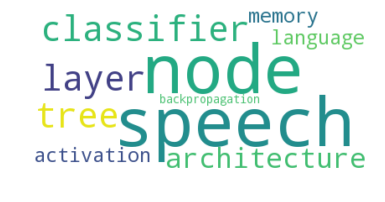

Topic 4


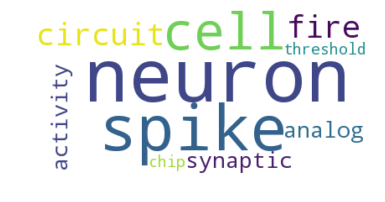

Topic 5


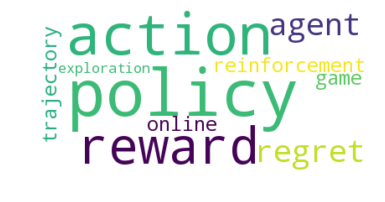

Topic 6


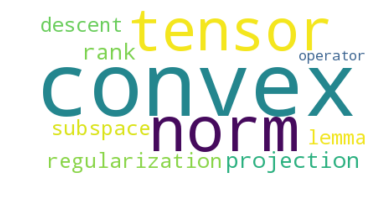

Topic 7


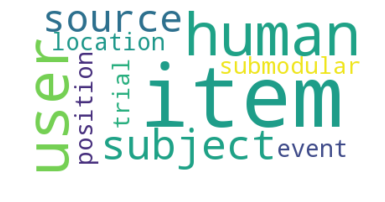

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

t = ldamodel.print_topics(num_topics=8, num_words=10)


wc = WordCloud(background_color= "white")

i = 0
for a in t:
    print("Topic " + str(i))
    wc.generate(a[1])
    img = wc.to_image()
 
    plt.imshow(img,interpolation="bilinear")
    plt.axis("off")
    plt.show()
    i = i+1

## Inter-topics distance map
Here, topics are dispalyed using the inter- topic distance map: in this view, we plot the topics as circles in the two-dimensional plane whose centers are determined by computing the distance between topics using multidimensional scaling to project the inter- topic distances onto two dimensions.
 https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [8]:
# the order of the topics is not the same of above 
import pyLDAvis.gensim
from gensim import corpora

from gensim import corpora
corpus = doc_term_matrix
#corpus = tfidf
data =  pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary)
pyLDAvis.display(data)


/Users/alessandroterragni/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


### Save topic for each document
For each documet we retrieve the best associated topic

In [9]:
documentTopics = []
docTopicWeights = []

for doc in lda:
    max = 0
    if(len(doc)==0): 
        documentTopics.append("unclassified")
        docTopicWeights.append(0)
        continue
        
    #calculating the maximum weights
    for p in doc:
        if p[1] >= max:
            max = p[1]
    max = round(max,4)
    
    for p in doc: 
        if (round(p[1],4)==max):
            documentTopics.append(p[0])
            docTopicWeights.append(max)
            break
    
d = {'paperId': papersId, 'topicId': documentTopics, 'topicWeight': docTopicWeights}
df = pd.DataFrame(data=d)
df.to_csv("ldaTopics.csv",index=False)

###  Retrieve best papers for each topic 
To give a meaningfull name to each topic and to validate it, we retrieve the best papers associated to each topic, in order to see the titles of these papers ( the lda model was not trained with the titles of the papers but just with the corpus )


In [10]:
topics = pd.read_csv("ldaTopics.csv")
topics.head(5)



bestTopics = []
best5 = []
numberOfTopics = 8

for i in range(0,numberOfTopics):
    topic = topics[topics.topicId == i]
    topic = topic.sort_values(['topicWeight'],ascending=False).head(5)
    for t in topic.iterrows():
        best5.append(t[0])
    bestTopics.append(best5)
    best5 = []

print(bestTopics)


[[6065, 6129, 6041, 6020, 6166], [4746, 4767, 6055, 2131, 4033], [6418, 4175, 6436, 2191, 6499], [6248, 182, 961, 6411, 6450], [6366, 6215, 6388, 1069, 6458], [4588, 6182, 1259, 2261, 6120], [6062, 6097, 6099, 5654, 6048], [6506, 3724, 6125, 1019, 1465]]


In [11]:
#to show the full text of the title
pd.options.display.max_colwidth = 100

j= 0
for i in bestTopics:
    print("topic " +str(j))
    for p in i:
        paperTitle = str(papers[papers.id==p].title)
        print(paperTitle)
    print("\n\n")
    j = j+1

topic 0
5597    Stochastic Online AUC Maximization
Name: title, dtype: object
5668    Reconstructing Parameters of Spreading Models from Partial Observations
Name: title, dtype: object
5571    Optimal Tagging with Markov Chain Optimization
Name: title, dtype: object
5548    Mixing Time Estimation in Reversible Markov Chains from a Single Sample Path
Name: title, dtype: object
5709    On Valid Optimal Assignment Kernels and Applications to Graph Classification
Name: title, dtype: object



topic 1
4139    MCMC for continuous-time discrete-state systems
Name: title, dtype: object
4161    Efficient Bayes-Adaptive Reinforcement Learning using Sample-Based Search
Name: title, dtype: object
5586    The Forget-me-not Process
Name: title, dtype: object
1242    Dynamic Time-Alignment Kernel in Support Vector Machine
Name: title, dtype: object
3350    Boosting Classifier Cascades
Name: title, dtype: object



topic 2
5989    Interaction Networks for Learning about Objects, Relations and Physics


### Furher researches
It would be interesting to try other models and compare the results with U_Mass Coherence and Using C_V coherence.

## Running LSI Model

In [ ]:
lsiModel = models.LsiModel(doc_term_matrix, id2word=dictionary, num_topics=5)
lsi = lsiModel[tfidf]

### LSI topics

In [ ]:
lsiModel.print_topics(num_topics=-1, num_words=5)

## Running Hierarchical Dirichlet Process
It automatically detects the number of topics

In [14]:
hdpModel = models.HdpModel(doc_term_matrix, id2word = dictionary)
hdp = hdpModel[tfidf]

### HDP topics

In [ ]:
hdpModel.print_topics(num_topics=8,num_words=5)

### EVALUATION

Using U_Mass Coherence

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

umc = CoherenceModel(model=ldamodel, corpus=doc_term_matrix, dictionary=dictionary, coherence='u_mass')
print(umc)
print(umc.get_coherence())

Using C_V coherence

In [ ]:
cvc = CoherenceModel(model=ldamodel, texts=  doc_term_matrix , dictionary=dictionary, coherence='c_v')
print(cvc)
print(cvc.get_coherence())